In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pointCollection as pc
import os
import h5py
import sparseqr
import LSsurf

plt.rcParams['animation.ffmpeg_path'] = os.path.join(os.environ['CONDA_PREFIX'],'bin','ffmpeg')

In [2]:
datafile = '/home/jovyan/shared-public/off_track/michael/all_ATL06.h5'
D = pc.data().from_h5(datafile, group='/')
print(D)

<class 'pointCollection.data.data'> with shape (260463,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y']


In [10]:
print('Data length')
print(D.x.shape)
print('x max')
print(D.x.max())
print('x min')
print(D.x.min())
print('y max')
print(D.y.max())
print('y min')
print(D.y.min())
print('x max')
print(D.x.max()+D.x.min())
print('x min')
print(D.x.min())
print('y max')
print(D.y.max())
print('y min')
print(D.y.min())

Data length
(260463,)
x max
-526065.9382232222
x min
-560245.6418096226
y max
-1157213.8247005173
y min
-1192156.465025961


In [3]:
x_max = D.x.max()
x_min = D.x.min()
x_cen = (x_min + x_max)/2
x_span = x_max - x_min
y_max = D.y.max()
y_min = D.y.min()
y_cen = (y_min + y_max)/2
y_span = y_max - y_min

print(x_span)
print(x_cen)
print(y_span)
print(y_cen)

34179.70358640049
-543155.7900164224
34942.640325443586
-1174685.144863239


In [4]:
print(np.nanmin(D.delta_time))
print(np.nanmax(D.delta_time))
D.assign(t = 2018.0 + D.delta_time/(365.25*86400))
#t = 2018.0 + D.delta_time/(365.25*86400)
t_min = np.nanmin(D.t)
t_max = np.nanmax(D.t)
t_cen = round(4*(t_min + t_max)/2)/4
t_span = t_max - t_min + 0.5

#D.t = t
print(D.t)
print(t_min)
print(t_max)
print(t_cen)
print(t_span)

39698264.62609916
199824735.4069943
[          nan           nan 2019.97810762 ... 2023.83476533 2024.08341445
 2024.33206376]
2019.2579620955364
2024.332063762992
2021.75
5.5741016674555794


In [5]:
print(D.dem_h.min())
print(D.dem_h.max())
D.assign(z = np.copy(D.dem_h))
print(D)

725.32056
1261.7234
<class 'pointCollection.data.data'> with shape (260463,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y', 't', 'z']


In [6]:
print(D)

<class 'pointCollection.data.data'> with shape (260463,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y', 't', 'z']


In [7]:
from LSsurf.smooth_fit import smooth_fit
E_d3zdx2dt=0.0001 # d/dt of the el diff map curvature
E_d2z0dx2=0.06 # 2nd diff of base el map
E_d2zdt2=5000 # Second time deriv of el diff.

data=D.copy()
#data.t /= 365.25
#data.assign(z=z_fn(data, **z_params))
data.assign({'sigma':np.zeros_like(data.z)+0.1})
print(data)

ctr={'x':x_cen,'y':y_cen,'t':t_cen} 
print(ctr)
W={'x':40000,'y':4e4,'t':t_span} # Numbers should span whats in data. Units don't matter. 
print(W)
spacing={'z0':100, 'dz':500, 'dt':0.25} # z0 is elevation spacing, dz is el. diff spacing, dt is temporal spacing between el. diff surfaces

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}

<class 'pointCollection.data.data'> with shape (260463,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y', 't', 'z', 'sigma']
{'x': -543155.7900164224, 'y': -1174685.144863239, 't': 2021.75}
{'x': 40000, 'y': 40000.0, 't': 5.5741016674555794}


In [8]:
# run the fit
S=smooth_fit(data=data, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=5, compute_E=False,
             max_iterations=1,
             VERBOSE=True, dzdt_lags=[1])
dz=S['m']['dz']
z0=S['m']['z0']
dz.t=dz.time
dz.cell_area=np.tile(dz.cell_area[:,:,None], [1,1, len(dz.t)])

smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 0.0001, 'd2z_dxdt': 0.25, 'd2z_dt2': 5000}
initial: 168490:
starting qr solve for iteration 0 at Wed Aug 21 00:15:26 2024
found 168466 in TSE, dt=564
	 median(sigma_extra)=0.0000


In [9]:
print(S)

{'m': {'z0': <class 'pointCollection.grid.data.data'> with shape (401, 401),
with fields:
['cell_area', 'mask', 'z0', 'count', 'misfit_scaled_rms', 'misfit_rms'], 'dz': <class 'pointCollection.grid.data.data'> with shape (81, 81, 23),
with fields:
['dz', 'cell_area', 'mask', 'count', 'misfit_scaled_rms', 'misfit_rms'], 'dzdt_lag1': <class 'pointCollection.grid.data.data'> with shape (81, 81),
with fields:
['cell_area', 'dzdt_lag1'], 'all': array([9.06672682e+02, 9.07108677e+02, 9.07544447e+02, ...,
       9.38564833e-05, 7.30951903e-05, 3.85227556e-05]), 'extent': array([ -563155.79001642,  -523155.79001642, -1194685.14486324,
       -1154685.14486324]), 'sensor_bias_grids': {}, 'jitter_bias_grids': {}}, 'E': {}, 'data': <class 'pointCollection.data.data'> with shape (168491,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y', 't', 'z', 'sigma'

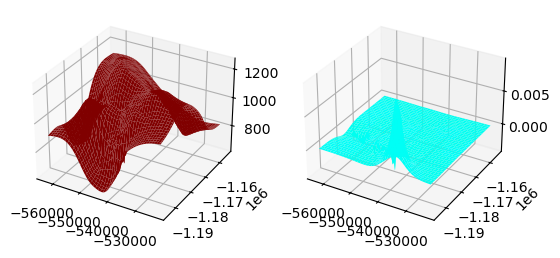

In [17]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
xg0, yg0=np.meshgrid(z0.x, z0.y)
hs=ax[0].plot_surface(xg0, yg0, z0.z0, vmin=-30, vmax=30, cmap='seismic')

xgd, ygd=np.meshgrid(dz.x, dz.y)

hs1=ax[1].plot_surface(xgd, ygd, dz.dz[:,:,10], vmin=-30, vmax=30, cmap='hsv')

In [18]:
from matplotlib import animation

def make_frame(i0, times, D, z0, dz, hax, zlim):
    """The animation function to call for each animation frame."""
    for ax in hax:
        ax.clear()

    ii = D.t<=times[i0]
    ax=hax[0]
    hs=ax.scatter(D.x[ii][::5], D.y[ii][::5], D.z[ii][::5], c=D.z[ii][::5], vmin=zlim[0], vmax=zlim[1], cmap='seismic_r')
    hs.set_facecolors(hs.get_facecolors()*np.array([0.25, 0.25, 0.25, 1]))
    hs.set_sizes([1])

    ii=(D.t>=times[i0]) & (D.t <= times[i0+1]) 
    hs1=ax.scatter(D.x[ii], D.y[ii], D.z[ii], c=D.z[ii],  vmin=zlim[0], vmax=zlim[1], cmap='seismic_r')
    hs1.set_sizes([2])

    xg, yg=np.meshgrid(dz.x, dz.y)
    zg0 = z0.interp(xg, yg, field='z0')
    dzi=dz.interp(xg, yg, np.zeros_like(zg0)+times[i0], field='dz')
    surf0 = hax[1].plot_surface(*np.meshgrid(z0.x, z0.y), z0.z0, vmin=zlim[0], vmax=zlim[1], cmap='seismic_r')
    surf1 = hax[2].plot_surface(xg, yg, dzi, vmin=zlim[0], vmax=zlim[1], cmap='seismic_r')
    surf2=hax[3].plot_surface(xg, yg, zg0 + dzi, vmin=zlim[0], vmax=zlim[1], cmap='seismic_r')
    ht=[hax[0].set_title('Data', color='white'),
        hax[1].set_title('reference DEM', color='white'),
        hax[2].set_title('elevation change', color='white'),
        hax[3].set_title('Total elevation', color='white')]

    for ax in hax:
        ax.set_zlim(zlim)
    return hax[0], hax[1], hs, hs1, surf0, surf1, surf2, *ht


def make_animation(D, dz, z0, t_steps, zlim):

    # 3D surface plot, black backgrounds, no padding around the Axes.
    fig, hax = plt.subplots(2,2, figsize=[8, 8], 
                            subplot_kw=dict(projection='3d', facecolor='k'),
                           facecolor='k', gridspec_kw={'left':0,'right':1, 'bottom':0.0,'top':0.9})
    hax=hax.ravel()
    # Initialize the plot.
    _ = make_frame(0, t_steps, D, z0, dz, hax, zlim)
    #for ax in hax:
    #    ax.axis('off')

    # The animation itself; no point in blitting: almost everything will change
    # in each animation frame.
    ani = animation.FuncAnimation(fig, make_frame, fargs=(t_steps, D, z0, dz, hax, zlim),
                                  interval=100, blit=False, frames=len(t_steps)-1)
    
    
    return ani
